In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns 
from functions import *
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from functions1 import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from matplotlib import pyplot

### Introduction

Mes missions :
Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

### Le jeu de données météo

https://cegibat.grdf.fr/simulateur/calcul-dju

![title](images/clime.png)

![title](images/chauffage.png)

#### Chauffage

In [2]:
meteo_chauffage=pd.read_excel("data/Chauffage.xlsx",skiprows=11)
meteo_chauffage=meteo_chauffage.rename(columns={"Unnamed: 0":"Année","JAN": "01",
                      "FÉV":"02",
                      "MAR":"03",
                      "AVR":"04",
                      "MAI":"05",
                      "JUN":"06",
                      "JUI":"07",
                      "AOÛ":"08",
                      "SEP":"09",
                      "OCT":"10",
                      "NOV":"11",
                      "DÉC":"12"})

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
#meteo_chauffage.loc[meteo_chauffage['Année']== 2020 ,:]

In [4]:
#indexNames =meteo_chauffage.loc[meteo_chauffage['Année']== 2020 ,:].index

In [5]:
#meteo_chauffage.drop(indexNames , inplace=True)
meteo_chauffage

,Année,01,02,03,04,05,06,07,08,09,10,11,12,Total
0,2021,396.7,302.8,271.0,228.3,138.3,1.4,0.0,0.0,0.0,0.0,0.0,0.0,1338.2
1,2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8,1785.9
2,2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3,1989.0
3,2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
4,2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
5,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
6,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
7,2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
8,2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
9,2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5


In [6]:
meteo_chauffage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Année   13 non-null     int64  
 1   01      13 non-null     float64
 2   02      13 non-null     float64
 3   03      13 non-null     float64
 4   04      13 non-null     float64
 5   05      13 non-null     float64
 6   06      13 non-null     float64
 7   07      13 non-null     float64
 8   08      13 non-null     float64
 9   09      13 non-null     float64
 10  10      13 non-null     float64
 11  11      13 non-null     float64
 12  12      13 non-null     float64
 13  Total   13 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 1.5 KB


In [7]:
meteo_chauffage.columns

Index(['Année', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', 'Total'],
      dtype='object')

In [8]:
meteo_chauffage=meteo_chauffage.set_index('Année')
meteo_chauffage=meteo_chauffage.drop(columns=['Total'])
meteo_chauffage

,01,02,03,04,05,06,07,08,09,10,11,12
Année,,,,,,,,,,,,
2021,396.7,302.8,271.0,228.3,138.3,1.4,0.0,0.0,0.0,0.0,0.0,0.0
2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8
2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3
2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9
2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8
2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1
2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2
2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5


In [9]:
meteo_chauffage.columns

Index(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], dtype='object')

In [10]:
meteo_newformat_chau={'mois':[],'chauffage':[]}
for Année in meteo_chauffage.index.values:
    for mois in meteo_chauffage.columns:
        meteo_newformat_chau['mois'].append(f"{Année}-{mois}-01")
        meteo_newformat_chau['chauffage'].append(meteo_chauffage.loc[Année,mois])

meteo_newformat_chau=pd.DataFrame(meteo_newformat_chau)
meteo_newformat_chau['mois']=pd.to_datetime(meteo_newformat_chau['mois'])

In [11]:
meteo_newformat_chau.head(n=5)

,mois,chauffage
0,2021-01-01,396.7
1,2021-02-01,302.8
2,2021-03-01,271.0
3,2021-04-01,228.3
4,2021-05-01,138.3


#### Climatisation

In [12]:
meteo_climat=pd.read_excel("data/Climatisation.xlsx",skiprows=11)
meteo_climat=meteo_climat.rename(columns={"Unnamed: 0":"Année","JAN": "01",
                      "FÉV":"02",
                      "MAR":"03",
                      "AVR":"04",
                      "MAI":"05",
                      "JUN":"06",
                      "JUI":"07",
                      "AOÛ":"08",
                      "SEP":"09",
                      "OCT":"10",
                      "NOV":"11",
                      "DÉC":"12"})

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [13]:
meteo_climat

,Année,01,02,03,04,05,06,07,08,09,10,11,12,Total
0,2021,0,0,0.2,0.9,5.1,47.6,0.0,0.0,0.0,0.0,0.0,0,53.8
1,2020,0,0,0.0,11.5,28.6,57.5,96.6,157.0,72.3,0.0,0.0,0,423.4
2,2019,0,0,0.0,5.7,3.2,100.1,152.3,115.6,22.6,4.0,0.0,0,403.3
3,2018,0,0,0.0,16.1,42.9,74.6,198.7,126.3,33.2,17.0,0.0,0,508.7
4,2017,0,0,0.0,0.0,47.2,111.9,108.3,80.5,8.5,2.7,0.0,0,358.9
5,2016,0,0,0.0,0.0,8.5,37.0,105.6,121.4,59.1,0.0,0.0,0,331.5
6,2015,0,0,0.0,2.3,2.8,64.8,139.1,122.4,1.0,0.0,0.3,0,332.6
7,2014,0,0,0.0,0.0,2.2,41.3,101.1,35.7,45.8,7.1,0.0,0,233.0
8,2013,0,0,0.0,3.8,0.0,29.9,152.1,89.2,27.1,4.3,0.0,0,306.2
9,2012,0,0,0.0,0.0,30.1,25.6,60.4,117.9,20.4,1.4,0.0,0,255.6


In [14]:
#meteo_climat.loc[meteo_climat['Année']== 2020 ,:]

In [15]:
#IndexNames =meteo_climat.loc[meteo_climat['Année']== 2020 ,:].index

In [16]:
#meteo_climat.drop(IndexNames , inplace=True)
meteo_climat

,Année,01,02,03,04,05,06,07,08,09,10,11,12,Total
0,2021,0,0,0.2,0.9,5.1,47.6,0.0,0.0,0.0,0.0,0.0,0,53.8
1,2020,0,0,0.0,11.5,28.6,57.5,96.6,157.0,72.3,0.0,0.0,0,423.4
2,2019,0,0,0.0,5.7,3.2,100.1,152.3,115.6,22.6,4.0,0.0,0,403.3
3,2018,0,0,0.0,16.1,42.9,74.6,198.7,126.3,33.2,17.0,0.0,0,508.7
4,2017,0,0,0.0,0.0,47.2,111.9,108.3,80.5,8.5,2.7,0.0,0,358.9
5,2016,0,0,0.0,0.0,8.5,37.0,105.6,121.4,59.1,0.0,0.0,0,331.5
6,2015,0,0,0.0,2.3,2.8,64.8,139.1,122.4,1.0,0.0,0.3,0,332.6
7,2014,0,0,0.0,0.0,2.2,41.3,101.1,35.7,45.8,7.1,0.0,0,233.0
8,2013,0,0,0.0,3.8,0.0,29.9,152.1,89.2,27.1,4.3,0.0,0,306.2
9,2012,0,0,0.0,0.0,30.1,25.6,60.4,117.9,20.4,1.4,0.0,0,255.6


In [17]:
meteo_climat=meteo_climat.set_index('Année')
meteo_climat=meteo_climat.drop(columns=['Total'])

In [18]:
meteo_climat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 2021 to 2009
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   01      13 non-null     int64  
 1   02      13 non-null     int64  
 2   03      13 non-null     float64
 3   04      13 non-null     float64
 4   05      13 non-null     float64
 5   06      13 non-null     float64
 6   07      13 non-null     float64
 7   08      13 non-null     float64
 8   09      13 non-null     float64
 9   10      13 non-null     float64
 10  11      13 non-null     float64
 11  12      13 non-null     int64  
dtypes: float64(9), int64(3)
memory usage: 1.3 KB


In [19]:
meteo_newformat_clim={'mois':[],'climatisation':[]}

for Année in meteo_climat.index.values:
    for mois in meteo_climat.columns:
        meteo_newformat_clim['mois'].append(f"{Année}-{mois}-01")
        meteo_newformat_clim['climatisation'].append(meteo_climat.loc[Année,mois])

meteo_newformat_clim=pd.DataFrame(meteo_newformat_clim)
meteo_newformat_clim['mois']=pd.to_datetime(meteo_newformat_clim['mois'])

In [20]:
meteo_newformat_clim.head(n=9)

,mois,climatisation
0,2021-01-01,0.0
1,2021-02-01,0.0
2,2021-03-01,0.2
3,2021-04-01,0.9
4,2021-05-01,5.1
5,2021-06-01,47.6
6,2021-07-01,0.0
7,2021-08-01,0.0
8,2021-09-01,0.0


In [21]:
dju=meteo_newformat_clim.merge(meteo_newformat_chau,on='mois',how='inner')
dju

,mois,climatisation,chauffage
0,2021-01-01,0.0,396.7
1,2021-02-01,0.0,302.8
2,2021-03-01,0.2,271.0
3,2021-04-01,0.9,228.3
4,2021-05-01,5.1,138.3
...,...,...,...
151,2009-08-01,117.9,0.9
152,2009-09-01,15.2,26.9
153,2009-10-01,4.8,149.6
154,2009-11-01,0.0,224.7


In [22]:
dju['dju']=dju['chauffage']+dju['climatisation']
dju

,mois,climatisation,chauffage,dju
0,2021-01-01,0.0,396.7,396.7
1,2021-02-01,0.0,302.8,302.8
2,2021-03-01,0.2,271.0,271.2
3,2021-04-01,0.9,228.3,229.2
4,2021-05-01,5.1,138.3,143.4
...,...,...,...,...
151,2009-08-01,117.9,0.9,118.8
152,2009-09-01,15.2,26.9,42.1
153,2009-10-01,4.8,149.6,154.4
154,2009-11-01,0.0,224.7,224.7


In [23]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   mois           156 non-null    datetime64[ns]
 1   climatisation  156 non-null    float64       
 2   chauffage      156 non-null    float64       
 3   dju            156 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 6.1 KB


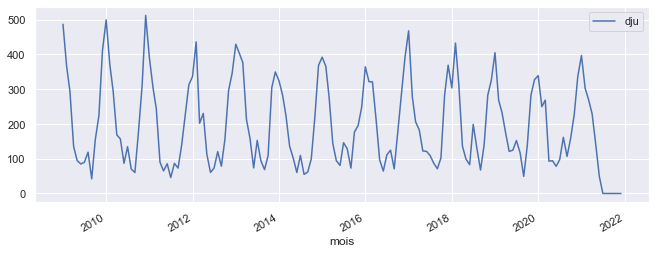

In [24]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
# Série sunspot : nombre annuel de tâches solaires de 1790 à 1970
dju.plot(y="dju",x='mois');

In [25]:
df = pd.read_csv("data/conso.csv",
                 encoding = "ISO-8859-1",
                 engine='python',
                 sep="\t")
df=df[['Mois','Territoire','Consommation totale']]

In [26]:
df

,Mois,Territoire,Consommation totale
0,2012-01,France,51086
1,2012-02,France,54476
2,2012-03,France,43156
3,2012-04,France,40176
4,2012-05,France,35257
...,...,...,...
1294,2021-03,Occitanie,3332
1295,2021-03,Normandie,2624
1296,2021-03,Hauts-de-France,4566
1297,2021-03,PACA,3597


In [27]:
consommation_france=df.loc[df['Territoire']=='France',['Mois','Consommation totale']]
consommation_france=consommation_france.drop(consommation_france.index[0]).reset_index(drop=True)
consommation_france['Mois']=pd.to_datetime(consommation_france["Mois"])
consommation_france=consommation_france.loc[consommation_france['Consommation totale']>0,:]

In [28]:
consommation_france=consommation_france.rename(columns={'Consommation totale': 'Consommation_totale'})

In [29]:
consommation_france.head(n=5)

,Mois,Consommation_totale
0,2012-02-01,54476
1,2012-03-01,43156
2,2012-04-01,40176
3,2012-05-01,35257
4,2012-06-01,33219


In [30]:
consommation_france.tail(n=4)

,Mois,Consommation_totale
106,2020-12-01,47565
107,2021-01-01,53006
108,2021-02-01,42979
109,2021-03-01,43341


In [31]:
consommation_france.info()
#On peut noter que nous n'avons pas de données manquantes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Mois                 110 non-null    datetime64[ns]
 1   Consommation_totale  110 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


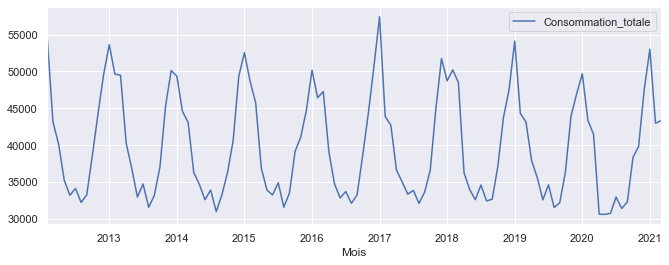

In [32]:
sns.set(rc={'figure.figsize':(11, 4)})
consommation_france.plot(y="Consommation_totale",x='Mois');

In [33]:
print(dju.shape)

(156, 4)


In [34]:
print(consommation_france.shape)

(110, 2)


In [35]:
Elec=consommation_france.merge(dju,left_on='Mois',right_on='mois')

In [36]:
Elec

,Mois,Consommation_totale,mois,climatisation,chauffage,dju
0,2012-02-01,54476,2012-02-01,0.0,435.9,435.9
1,2012-03-01,43156,2012-03-01,0.0,201.9,201.9
2,2012-04-01,40176,2012-04-01,0.0,230.3,230.3
3,2012-05-01,35257,2012-05-01,30.1,83.3,113.4
4,2012-06-01,33219,2012-06-01,25.6,35.0,60.6
...,...,...,...,...,...,...
105,2020-11-01,39840,2020-11-01,0.0,227.2,227.2
106,2020-12-01,47565,2020-12-01,0.0,336.8,336.8
107,2021-01-01,53006,2021-01-01,0.0,396.7,396.7
108,2021-02-01,42979,2021-02-01,0.0,302.8,302.8


In [37]:
print(Elec.columns)

Index(['Mois', 'Consommation_totale', 'mois', 'climatisation', 'chauffage',
       'dju'],
      dtype='object')


In [38]:
Elec=Elec.drop(['mois','chauffage','climatisation'],axis=1).set_index('Mois')

In [39]:
Elec= Elec[:-1]
Elec=Elec.fillna(0)

In [40]:
Elec.describe()

,Consommation_totale,dju
count,109.000000,109.000000
mean,39784.605505,201.462385
std,7091.369846,113.810190
min,30622.000000,49.300000
25%,33374.000000,102.400000
50%,37102.000000,161.500000
75%,44960.000000,296.200000
max,57406.000000,467.900000


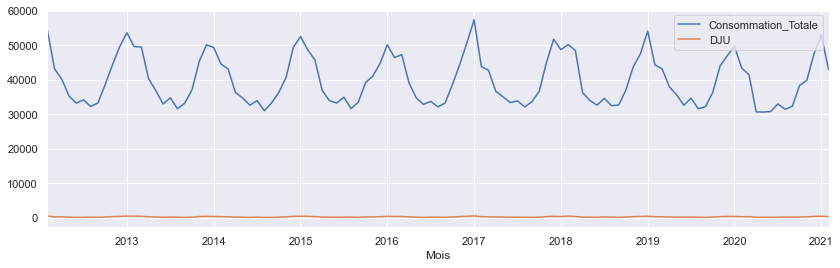

In [41]:
Elec['Consommation_totale'].plot(figsize=(14,4),label="Consommation_Totale")
Elec['dju'].plot(figsize=(14,4),label="DJU")
plt.legend();

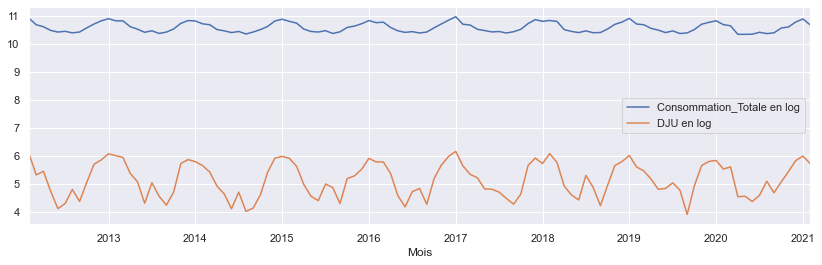

In [42]:
np.log(Elec['Consommation_totale']).plot(figsize=(14,4),label="Consommation_Totale en log")
np.log(Elec['dju']).plot(figsize=(14,4),label="DJU en log")
plt.legend();

# Q_1

Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

## Désaisonnalisez à l'aide de la régression linéaire

![title](images/addi-multi.png)

In [43]:
Elec.head(n=2)

,Consommation_totale,dju
Mois,,
2012-02-01,54476,435.9
2012-03-01,43156,201.9


In [44]:
Elec['t']=range(1, Elec.shape[0]+1)

In [45]:
Elec.head(n=5)

,Consommation_totale,dju,t
Mois,,,
2012-02-01,54476,435.9,1
2012-03-01,43156,201.9,2
2012-04-01,40176,230.3,3
2012-05-01,35257,113.4,4
2012-06-01,33219,60.6,5


In [46]:
y=Elec['Consommation_totale']
x=Elec.drop(columns=['Consommation_totale'])

In [47]:
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(x, y)
regression=reg.fit(x, y)
regression

LinearRegression()

In [48]:
print(reg.coef_,reg.intercept_)
#Ici nous avons le coefficient du dju et le 2ème coeff correspond à t=temps
#les coeff sont affichés ds cette ordre puisque ils sont ds cet ordre ds le dataset


[ 60.35192562 -14.68978545] 28433.900809390787


In [49]:
#le coefficient du dju 
c = reg.coef_[0]
c 

60.351925623451834

In [50]:
# calcule de serie corrigée
serie_corrigee = Elec['Consommation_totale'] - Elec['dju']*c 
serie_corrigee 

Mois
2012-02-01    28168.595621
2012-03-01    30970.946217
2012-04-01    26276.951529
2012-05-01    28413.091634
2012-06-01    29561.673307
                  ...     
2020-10-01    28826.571714
2020-11-01    26128.042498
2020-12-01    27238.471450
2021-01-01    29064.391105
2021-02-01    24704.436921
Length: 109, dtype: float64

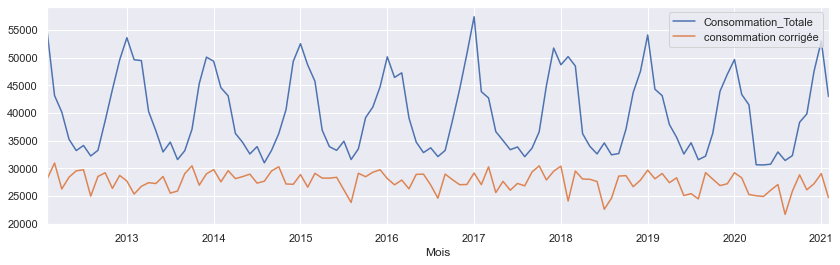

In [51]:
#serie_corrigee = x_cvs.rename("CVS")
Elec['Consommation_totale'].plot(figsize=(14,4),label="Consommation_Totale")
serie_corrigee.plot(label='consommation corrigée')
plt.legend();

In [52]:
#Elec.corr(method="pearson")
Elec.corr(method='pearson').style.format('{:8}').background_gradient(cmap=pyplot.get_cmap("coolwarm"))#coeff corr pearson  

,Consommation_totale,dju,t
Consommation_totale,1.0,0.968367476650693,-0.062116312769860425
dju,0.968367476650693,1.0,0.003472066833825364
t,-0.062116312769860425,0.003472066833825364,1.0


In [53]:
Elec.Consommation_totale.values.reshape(1,-1).shape

(1, 109)

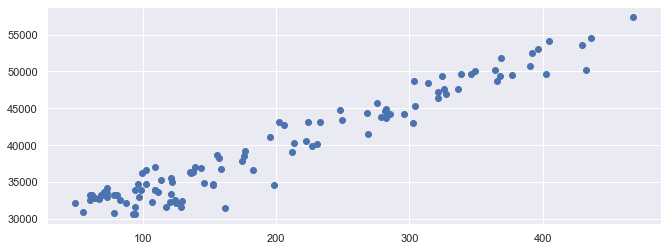

In [54]:
plt.scatter(Elec.dju,Elec.Consommation_totale);
#plt.plot(Elec.dju,regression.predict(Elec.Consommation_totale.values.reshape(1,-1)),Elec.dju)

# Q_2

Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

In [55]:
reg_multip = smf.ols('Consommation_totale ~ dju', data=Elec).fit()

In [56]:
print(reg_multip.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation_totale   R-squared:                       0.938
Model:                             OLS   Adj. R-squared:                  0.937
Method:                  Least Squares   F-statistic:                     1611.
Date:                 Mon, 08 Nov 2021   Prob (F-statistic):           2.46e-66
Time:                         23:49:59   Log-Likelihood:                -969.31
No. Observations:                  109   AIC:                             1943.
Df Residuals:                      107   BIC:                             1948.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.763e+04    347.403     79.53

In [57]:
serie_corr_Elec = pd.DataFrame({'Mois':serie_corrigee.index, 'corrigee':serie_corrigee.values})

### Test de normalité des résidus

In [58]:
# shapiro
shapiro(reg_multip.resid)

ShapiroResult(statistic=0.964981734752655, pvalue=0.0057502915151417255)

la test de normalité n'est pas rejet car p>0.05

In [59]:
#reg_multip.plot_diagnostics(figsize=(16, 10))
#plt.tight_layout()
#plt.show()

[('Lagrande multiplier statistic', 0.510542090451406), ('p-value', 0.4749042834015045), ('f-value', 0.5035328291882991), ('f p-value', 0.47949540648505273)]
Shapiro pvalue : 0.0057501704432070255


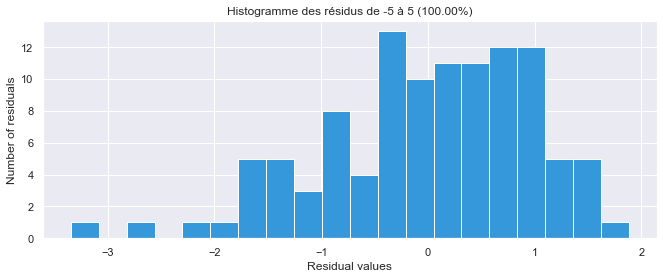

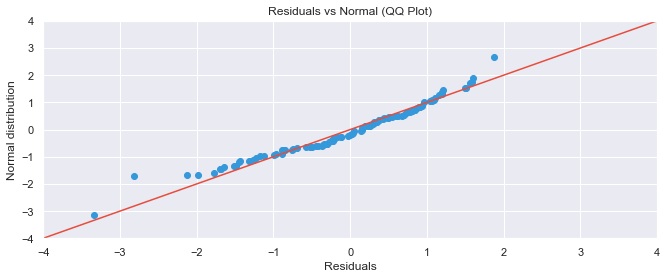

In [60]:
linear_regression_analysis(reg_multip)

# Désaisonnaliser 

In [61]:
serie_corr_Elec.tail(n=8)

,Mois,corrigee
101,2020-07-01,27085.687252
102,2020-08-01,21681.164012
103,2020-09-01,25873.484729
104,2020-10-01,28826.571714
105,2020-11-01,26128.042498
106,2020-12-01,27238.471450
107,2021-01-01,29064.391105
108,2021-02-01,24704.436921


#### moyenne mobile

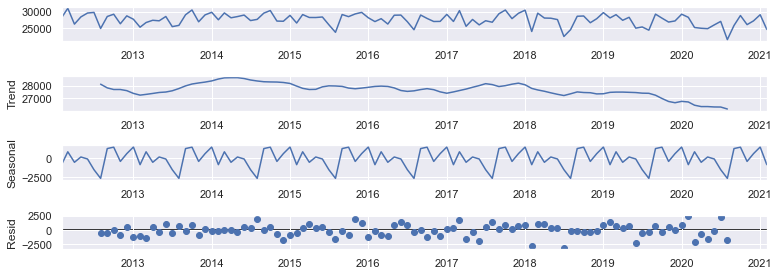

In [62]:
# algo simplifie de décomposition saisionière à l'aide de moyennes mobile 
decomp_x = seasonal_decompose(serie_corrigee, model='additive')
decomp_x.plot()
plt.show() ;

In [63]:
serie_corr_Elec['corrigee-saison']=serie_corrigee.values-decomp_x.seasonal.values

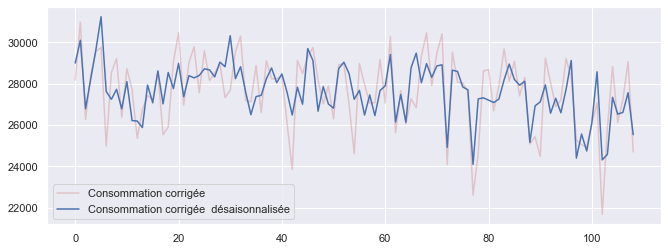

In [64]:
plt.plot(serie_corr_Elec["corrigee"],'r', label="Consommation corrigée",alpha=0.25)
plt.plot(serie_corr_Elec["corrigee-saison"],'b', label="Consommation corrigée  désaisonnalisée")
plt.legend()
plt.show()

##### la méthode de Holt-Winters :

In [65]:
x_tronc = serie_corr_Elec.iloc[:-12,:]
x_tronc

,Mois,corrigee,corrigee-saison
0,2012-02-01,28168.595621,28999.082990
1,2012-03-01,30970.946217,30099.702981
2,2012-04-01,26276.951529,26791.685562
3,2012-05-01,28413.091634,28229.184576
4,2012-06-01,29561.673307,29642.902326
...,...,...,...
92,2019-10-01,28056.539842,26573.696583
93,2019-11-01,26889.545819,27290.820321
94,2019-12-01,27220.814743,26595.134156
95,2020-01-01,29216.697214,27718.455357


In [66]:
y= np.asarray(x_tronc["corrigee"])
hw = ExponentialSmoothing(y, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [67]:
hw.params

{'smoothing_level': 0.040357142857142855,
 'smoothing_trend': 0.040357142857142855,
 'smoothing_seasonal': 0.3770025510204082,
 'damping_trend': nan,
 'initial_level': 26923.387046897282,
 'initial_trend': -46.11222240229043,
 'initial_seasons': array([ 1245.20857384,  4047.55916973,  -646.43551798,  1489.7045874 ,
         2638.28626032,  2823.99276772, -1936.7236994 ,  1614.02198422,
         2289.71255584,  -539.62741656,  1802.88187995,   792.56647552]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

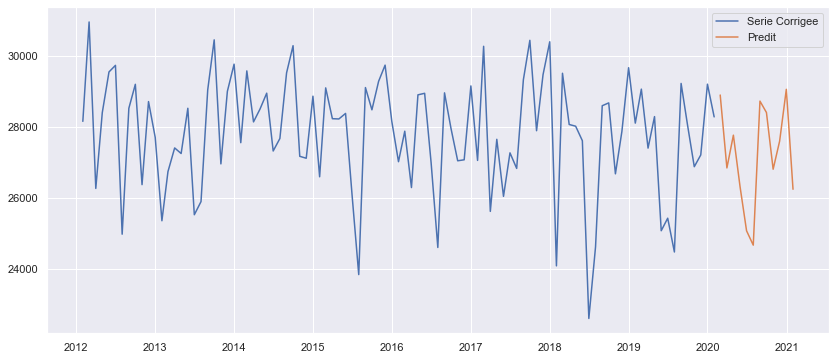

In [68]:
plt.figure(figsize=(14,6))
plt.plot(x_tronc['Mois'],x_tronc['corrigee'], label='Serie Corrigee')
plt.plot(pd.date_range(x_tronc.Mois[x_tronc.shape[0]-1],
                       periods=12, freq='M'), hw_pred, label='Predit')
plt.legend() ;

In [69]:
serie_corr_Elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mois             109 non-null    datetime64[ns]
 1   corrigee         109 non-null    float64       
 2   corrigee-saison  109 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.7 KB


In [70]:
x_tronc = serie_corr_Elec.iloc[:-12,:]
#y_tronc = np.log(x_tronc)
x_a_prevoir = serie_corr_Elec.iloc[-12:,:]

In [71]:
y= np.asarray(x_tronc["corrigee"])
hw = ExponentialSmoothing(y, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [72]:
x_a_prevoir['prediction']=hw_pred.copy()

<ipython-input-72-c18679352a8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_a_prevoir['prediction']=hw_pred.copy()


In [73]:
MAE=np.abs(x_a_prevoir['corrigee']-x_a_prevoir['prediction']).mean()
MAE

1620.9409644067662

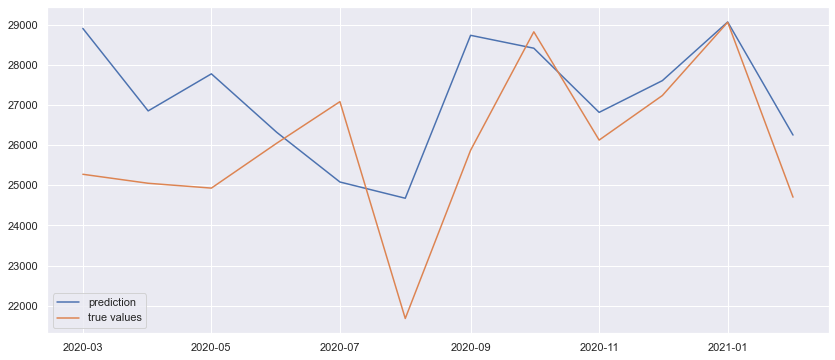

In [74]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir['Mois'],x_a_prevoir['prediction'], label='prediction')
plt.plot(x_a_prevoir['Mois'],x_a_prevoir['corrigee'], label='true values')
plt.legend()

## SARIMA

### Stationnarisation

In [75]:
adfuller(serie_corr_Elec['corrigee'])[1]

0.8294104500821697

adfuller : H0 la serie n'est pas stationnaire'

In [76]:
kpss(serie_corr_Elec['corrigee'])[1]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


0.03370308846693693

P_values

KPSS : H0 la serie est stationnaire 
    
    P_values<5% rejette H0

Ici on accepte mais la P-value tres proche du seuil critique

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


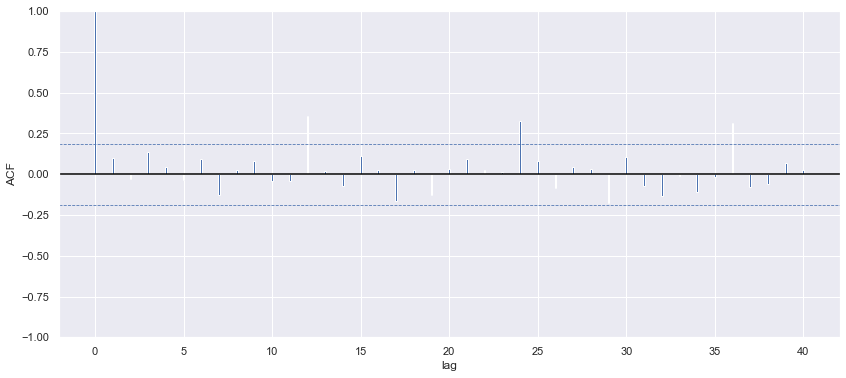

In [77]:
y_len = len(serie_corr_Elec['corrigee']) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(serie_corr_Elec['corrigee'])), y_len)

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation (𝐼−𝐵) 

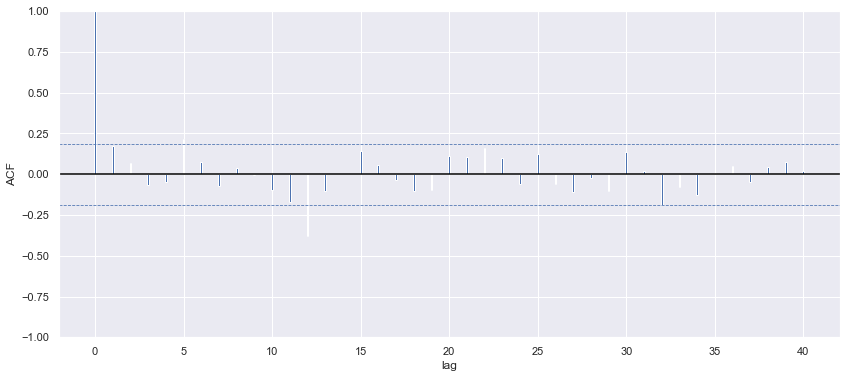

In [78]:
y_dif1 = serie_corr_Elec['corrigee'] - serie_corr_Elec['corrigee'].shift(12)

plot_sortie_acf(acf(np.asarray(y_dif1[13:])), y_len)

q=1 Q=1

In [79]:
adfuller(y_dif1[12:])[1]
#adfuller : H0 la serie n'est pas stationnaire'

0.00020016004074431518

In [80]:
kpss(y_dif1[12:])[1]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 24. On effectue cette fois la différenciation (𝐼−𝐵^12) 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


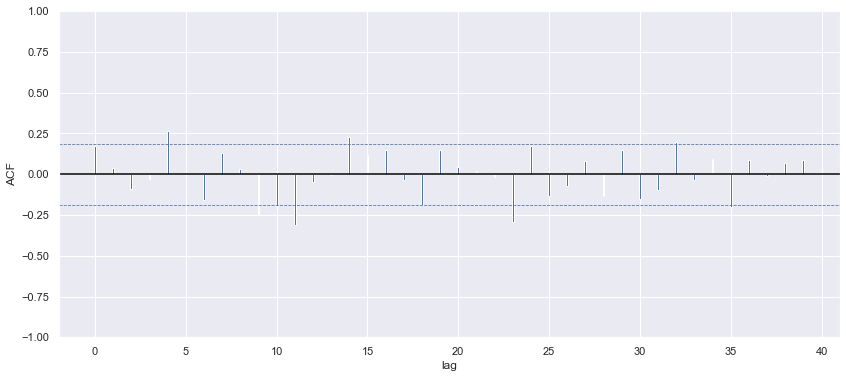

In [81]:
plot_sortie_acf(pacf(np.asarray(y_dif1[13:])), y_len, pacf=True)

## SARIMAX

In [82]:
model1 = SARIMAX(np.asarray(x_tronc["corrigee"]), order=(1,1,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   97
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -750.276
Date:                            Mon, 08 Nov 2021   AIC                           1510.551
Time:                                    23:50:37   BIC                           1522.706
Sample:                                         0   HQIC                          1515.437
                                             - 97                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2993      0.251      1.195      0.232      -0.192       0.790
ma.L1         -0.5297      0.241   

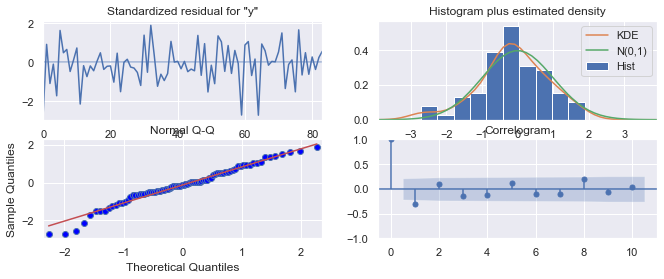

In [83]:
results1.plot_diagnostics()
plt.show()

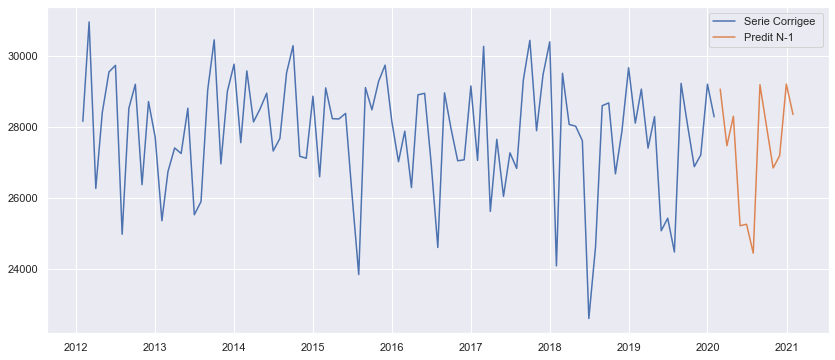

In [84]:
model1 = SARIMAX(np.asarray(x_tronc["corrigee"]), order=(1,0,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
sarima_pred=results1.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x_tronc['Mois'],x_tronc['corrigee'], label='Serie Corrigee ')
plt.plot(pd.date_range(x_tronc.Mois[x_tronc.shape[0]-1],
                       periods=12, freq='M'), sarima_pred, label='Predit N-1')
plt.legend() ;

In [85]:
pred_model2tronc = results1.get_forecast(12)
pred_tronc = pred_model2tronc.predicted_mean
MAE_sarima_model2=np.abs(x_a_prevoir['corrigee']-pred_tronc).mean()
MAE_sarima_model2

1976.4174959276188

In [86]:
serie_corr_Elec.shape

(109, 3)

## Optimal SARIMA

In [87]:
MAE_sarima_model_optim=np.abs(x_a_prevoir['corrigee']-pred_tronc).mean()
MAE_sarima_model_optim

1976.4174959276188

## Prédiction pour année+1

In [88]:
y= np.asarray(serie_corr_Elec["corrigee"])
hw = ExponentialSmoothing(y, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


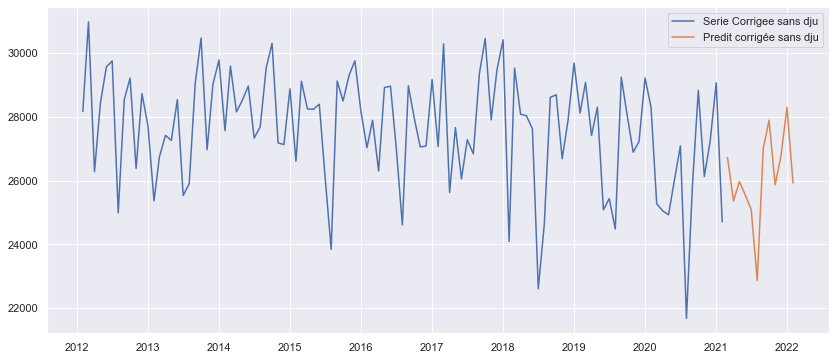

In [89]:
plt.figure(figsize=(14,6))
plt.plot(serie_corr_Elec['Mois'],serie_corr_Elec['corrigee'], label='Serie Corrigee sans dju')
plt.plot(pd.date_range(serie_corr_Elec.Mois[len(y)-1],
                       periods=12, freq='M'), hw_pred, label='Predit corrigée sans dju')
plt.legend();